

## **Buisness Problem**: Retail Analysis (Cross-sell & Up-sell)



# **Dataset** 
(Online Retail.xlsx)

In [83]:
import numpy as np
import pandas as pd

In [84]:
! git clone https://github.com/Swapnil-Damate/Upselling-and-cross-selling-.git
#written by Swapnil


fatal: destination path 'Upselling-and-cross-selling-' already exists and is not an empty directory.


In [85]:
dataset = pd.read_excel('/content/Upselling-and-cross-selling-/Online Retail.xlsx')
df = dataset.copy()
#written By Swapnil

## **Exploratory Data Analysis (EDA)**

In [86]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [87]:
 df=df[['CustomerID','InvoiceNo','StockCode','Quantity','UnitPrice','Description','InvoiceDate','Country']]

In [88]:
       #Creating Total amount variable and adding it to dataset
TotalAmount=df['Quantity']*df['UnitPrice']
df.insert(loc=6,column='TotalAmount',value=TotalAmount)
df=df[['CustomerID','InvoiceNo','StockCode','Quantity','UnitPrice','TotalAmount','Description','InvoiceDate','Country']]
df.head()

,CustomerID,InvoiceNo,StockCode,Quantity,UnitPrice,TotalAmount,Description,InvoiceDate,Country
0,17850.0,536365,85123A,6,2.55,15.30,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-01 08:26:00,United Kingdom
1,17850.0,536365,71053,6,3.39,20.34,WHITE METAL LANTERN,2010-12-01 08:26:00,United Kingdom
2,17850.0,536365,84406B,8,2.75,22.00,CREAM CUPID HEARTS COAT HANGER,2010-12-01 08:26:00,United Kingdom
3,17850.0,536365,84029G,6,3.39,20.34,KNITTED UNION FLAG HOT WATER BOTTLE,2010-12-01 08:26:00,United Kingdom
4,17850.0,536365,84029E,6,3.39,20.34,RED WOOLLY HOTTIE WHITE HEART.,2010-12-01 08:26:00,United Kingdom


In [89]:
                                                  #Total amount of purchases for each customer
new_df=df.groupby(['CustomerID']).sum()
new_df.sort_values('TotalAmount',ascending=False,inplace=True)
final_df = new_df[(new_df['Quantity']>0) & (new_df['TotalAmount'] > 0)]
final_df.head(10)

,Quantity,UnitPrice,TotalAmount
CustomerID,,,
14646.0,196719,5400.21,279489.02
18102.0,64122,5159.73,256438.49
17450.0,69029,3320.09,187482.17
14911.0,77180,31060.66,132572.62
12415.0,77242,2499.82,123725.45
14156.0,57025,6544.29,113384.14
17511.0,63012,2607.08,88125.38
16684.0,49390,709.93,65892.08
13694.0,61803,1163.81,62653.10


In [90]:
dff = df.copy()
dff = dff.drop('CustomerID',axis=1)

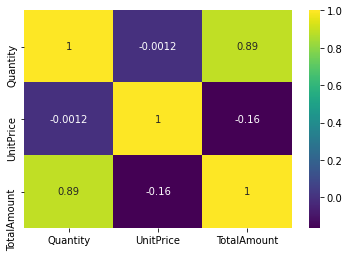

In [91]:
import seaborn as sns
sns.heatmap(dff.corr(),annot=True,cmap='viridis')

In [92]:
                                                             #Customer who paid most and least
print('Customer ID {} had paid maximum amount of {}'.format(int(final_df['TotalAmount'].argmax()),final_df['TotalAmount'].max()))
print('Customer ID {} had paid minimum amount of {}'.format(int(final_df['TotalAmount'].argmin()),final_df['TotalAmount'].min()))

Customer ID 0 had paid maximum amount of 279489.0199999999
Customer ID 4314 had paid minimum amount of 2.8999999999941792


In [93]:
                                                            #Maximum and Minimum no. of quantity and it's corresponding customer ID 
print('The maximum number of products has been bought is {} by customer id {}'.format(final_df['Quantity'].max(),final_df['Quantity'].argmax()))
print('The minimum number of product has been bought is {} by customer id {}'.format(final_df['Quantity'].min(),final_df['Quantity'].argmin()))

The maximum number of products has been bought is 196719 by customer id 0
The minimum number of product has been bought is 1 by customer id 858


In [94]:
                                            #Total sales at each country and how many quantities sold at each country
country=df.groupby(['Country']).sum()
country.sort_values('TotalAmount',ascending=False,inplace=True)
country.drop('CustomerID',axis=1,inplace=True)
country.head()

,Quantity,UnitPrice,TotalAmount
Country,,,
United Kingdom,4263829,2.245715e+06,8.187806e+06
Netherlands,200128,6.492550e+03,2.846615e+05
EIRE,142637,4.844719e+04,2.632768e+05
Germany,117448,3.766600e+04,2.216982e+05
France,110480,4.303199e+04,1.974039e+05


# **Data Cleaning / Data Preprocessing**

In [95]:
df.shape

(541909, 9)

In [96]:
df.describe()

,CustomerID,Quantity,UnitPrice,TotalAmount
count,406829.000000,541909.000000,541909.000000,541909.000000
mean,15287.690570,9.552250,4.611114,17.987795
std,1713.600303,218.081158,96.759853,378.810824
min,12346.000000,-80995.000000,-11062.060000,-168469.600000
25%,13953.000000,1.000000,1.250000,3.400000
50%,15152.000000,3.000000,2.080000,9.750000
75%,16791.000000,10.000000,4.130000,17.400000
max,18287.000000,80995.000000,38970.000000,168469.600000


In [97]:
#To remove extra spaces in Description if present
df['Description'] = df['Description'].str.strip()

In [98]:
#Drop NaN Entries
df.dropna()
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df['StockCode'] = df['StockCode'].astype('str')
df.shape

(541909, 9)

In [99]:
#Remove cancelled/Retured Transaction
df = df[~df['InvoiceNo'].str.contains('C')]

df = df[~df['InvoiceNo'].str.contains('A')]


# **Feature Engineering**

In [100]:

df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 532618, dtype: datetime64[ns]

In [101]:
df['year']=df['InvoiceDate'].apply(lambda date:date.year)
df['month']=df['InvoiceDate'].apply(lambda date:date.month)

# **Evaluate Algorithm**

In [102]:
!pip install mlxtend==0.17.0
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori

In [103]:
basket_Germany = (df[df['Country'] == 'Germany']
             .groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))
basket_Germany.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket_Germany.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

## Apriori Algorithm

In [105]:
frequent_items = apriori(basket_sets, min_support=0.02, use_colnames=True)
rules = association_rules(frequent_items, metric='lift', min_threshold=0.7)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(3 PIECE SPACEBOY COOKIE CUTTER SET),(ROUND SNACK BOXES SET OF4 WOODLAND),0.041575,0.245077,0.021882,0.526316,2.147556,0.011693,1.593727
1,(ROUND SNACK BOXES SET OF4 WOODLAND),(3 PIECE SPACEBOY COOKIE CUTTER SET),0.245077,0.041575,0.021882,0.089286,2.147556,0.011693,1.052388
2,(CHOCOLATE BOX RIBBONS),(6 RIBBONS RUSTIC CHARM),0.037199,0.102845,0.021882,0.588235,5.719650,0.018056,2.178806
3,(6 RIBBONS RUSTIC CHARM),(CHOCOLATE BOX RIBBONS),0.102845,0.037199,0.021882,0.212766,5.719650,0.018056,1.223017
4,(PLASTERS IN TIN CIRCUS PARADE),(6 RIBBONS RUSTIC CHARM),0.115974,0.102845,0.024070,0.207547,2.018065,0.012143,1.132125


In [106]:
rules[ (rules['lift'] >= 6) &
       (rules['confidence'] >= 0.80) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
49,(BLUE POLKADOT BOWL),(RED RETROSPOT CUP),0.032823,0.070022,0.026258,0.800000,11.425000,0.023960,4.649891
65,(BLUE STRIPE CERAMIC DRAWER KNOB),(RED STRIPE CERAMIC DRAWER KNOB),0.028446,0.045952,0.024070,0.846154,18.413919,0.022763,6.201313
66,(BLUE STRIPE CERAMIC DRAWER KNOB),(WHITE SPOT RED CERAMIC DRAWER KNOB),0.028446,0.052516,0.024070,0.846154,16.112179,0.022576,6.158643
68,(PINK VINTAGE SPOT BEAKER),(BLUE VINTAGE SPOT BEAKER),0.024070,0.030635,0.024070,1.000000,32.642857,0.023333,inf
89,(CHARLOTTE BAG SUKI DESIGN),(WOODLAND CHARLOTTE BAG),0.045952,0.126915,0.037199,0.809524,6.378489,0.031367,4.583698
101,(CHILDRENS CUTLERY SPACEBOY),(CHILDRENS CUTLERY DOLLY GIRL),0.048140,0.050328,0.039387,0.818182,16.256917,0.036965,5.223195
110,(COFFEE MUG PEARS DESIGN),(COFFEE MUG APPLES DESIGN),0.039387,0.061269,0.035011,0.888889,14.507937,0.032598,8.448578
125,(DINOSAUR PARTY BAG + STICKER SET),(WOODLAND PARTY BAG + STICKER SET),0.021882,0.067834,0.021882,1.000000,14.741935,0.020398,inf
126,(DOLLY GIRL CHILDRENS CUP),(DOLLY GIRL CHILDRENS BOWL),0.024070,0.026258,0.024070,1.000000,38.083333,0.023438,inf
127,(DOLLY GIRL CHILDRENS BOWL),(DOLLY GIRL CHILDRENS CUP),0.026258,0.024070,0.024070,0.916667,38.083333,0.023438,11.711160


# FpGrowth Algorithm

In [107]:
frequent_items2 = fpgrowth(basket_sets,
                          min_support = 0.02, use_colnames = True)
rules2 = association_rules(frequent_items2, metric="lift", min_threshold=1)
rules2.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(JUMBO BAG WOODLAND ANIMALS),(WOODLAND CHARLOTTE BAG),0.100656,0.126915,0.048140,0.478261,3.768366,0.035365,1.673414
1,(WOODLAND CHARLOTTE BAG),(JUMBO BAG WOODLAND ANIMALS),0.126915,0.100656,0.048140,0.379310,3.768366,0.035365,1.448942
2,(PLASTERS IN TIN WOODLAND ANIMALS),(JUMBO BAG WOODLAND ANIMALS),0.137856,0.100656,0.028446,0.206349,2.050035,0.014570,1.133173
3,(JUMBO BAG WOODLAND ANIMALS),(PLASTERS IN TIN WOODLAND ANIMALS),0.100656,0.137856,0.028446,0.282609,2.050035,0.014570,1.201777
4,(ROUND SNACK BOXES SET OF4 WOODLAND),(JUMBO BAG WOODLAND ANIMALS),0.245077,0.100656,0.037199,0.151786,1.507958,0.012531,1.060279


In [108]:
Rules = rules2[ (rules2['lift'] >= 6) &
       (rules2['confidence'] >= 0.80) ]
Rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,(JAM JAR WITH GREEN LID),(JAM JAR WITH PINK LID),0.035011,0.063457,0.032823,0.93750,14.773707,0.030601,14.984683
45,"(JUMBO BAG RED RETROSPOT, WOODLAND CHARLOTTE BAG)",(JUMBO BAG WOODLAND ANIMALS),0.024070,0.100656,0.024070,1.00000,9.934783,0.021647,inf
158,(RED RETROSPOT CHARLOTTE BAG),(WOODLAND CHARLOTTE BAG),0.070022,0.126915,0.059081,0.84375,6.648168,0.050194,5.587746
170,"(ROUND SNACK BOXES SET OF4 WOODLAND, RED RETRO...",(WOODLAND CHARLOTTE BAG),0.030635,0.126915,0.030635,1.00000,7.879310,0.026747,inf
176,"(SPACEBOY LUNCH BOX, RED RETROSPOT CHARLOTTE BAG)",(WOODLAND CHARLOTTE BAG),0.021882,0.126915,0.021882,1.00000,7.879310,0.019105,inf


# Result Visualization

In [109]:
#result.to_excel('/content/drive/My Drive/Internship Model Result/Final_retail_result.xlsx')
final_Table = pd.read_excel('/content/Upselling-and-cross-selling-/Final_onlineretail_result.xlsx')
final_Table = final_Table.drop('Unnamed: 0', axis=1)
final_Table = final_Table.drop('Unnamed: 0.1', axis=1)
final_Table = final_Table.replace()
final_Table

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,JAM JAR WITH GREEN LID,JAM JAR WITH PINK LID,0.035011,0.063457,0.032823,0.937500,14.773707,0.030601,14.984683
1,"JUMBO BAG RED RETROSPOT, WOODLAND CHARLOTTE BAG",JUMBO BAG WOODLAND ANIMALS,0.024070,0.100656,0.024070,1.000000,9.934783,0.021647,inf
2,RED RETROSPOT CHARLOTTE BAG,WOODLAND CHARLOTTE BAG,0.070022,0.126915,0.059081,0.843750,6.648168,0.050194,5.587746
3,"ROUND SNACK BOXES SET OF4 WOODLAND, RED RETROS...",WOODLAND CHARLOTTE BAG,0.030635,0.126915,0.030635,1.000000,7.879310,0.026747,inf
4,"RED RETROSPOT CHARLOTTE BAG, SPACEBOY LUNCH BOX",WOODLAND CHARLOTTE BAG,0.021882,0.126915,0.021882,1.000000,7.879310,0.019105,inf
5,"RED RETROSPOT CHARLOTTE BAG, RED TOADSTOOL LED...",WOODLAND CHARLOTTE BAG,0.024070,0.126915,0.024070,1.000000,7.879310,0.021015,inf
6,"JUMBO BAG WOODLAND ANIMALS, RED RETROSPOT CHAR...",WOODLAND CHARLOTTE BAG,0.024070,0.126915,0.021882,0.909091,7.163009,0.018827,9.603939
7,JUMBO BAG PINK POLKADOT,JUMBO BAG RED RETROSPOT,0.035011,0.078775,0.032823,0.937500,11.901042,0.030065,14.739606
8,"JUMBO BAG WOODLAND ANIMALS, JUMBO BAG PINK POL...",JUMBO BAG RED RETROSPOT,0.026258,0.078775,0.026258,1.000000,12.694444,0.024190,inf
9,"JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROSPOT",JUMBO BAG WOODLAND ANIMALS,0.032823,0.100656,0.026258,0.800000,7.947826,0.022954,4.496718


##**MODEL**

# CROSS-SELL

1.

In [110]:
def recme(antecedents):
  consequent = final_Table.loc[final_Table['antecedents'] == antecedents, 'consequents'].tolist()
  return consequent[0]

In [111]:
recme('SPACEBOY CHILDRENS CUP')

'SPACEBOY CHILDRENS BOWL'

2.

In [112]:
data_ib = (df[df['Country'] == 'Germany']
             .groupby(['CustomerID', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('CustomerID'))
data_ib.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12426.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12427.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12468.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12471.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12472.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,25.0,0.0,0.0,25.0,25.0,25.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,25.0,25.0,25.0,25.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
data_ib=data_ib.reset_index()
data_ib.head()

Description,CustomerID,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
0,12426.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12427.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12468.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12471.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12472.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,25.0,0.0,0.0,25.0,25.0,25.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,25.0,25.0,25.0,25.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
data_ib=data_ib.drop('CustomerID', 1)
data_ib.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,25.0,0.0,0.0,25.0,25.0,25.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,25.0,25.0,25.0,25.0,25.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
#Description v/s Description
data_ibs = pd.DataFrame(index=data_ib.columns,
                        columns=data_ib.columns)
data_ibs.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
Description,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 COLOUR SPACEBOY PEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 COLOURED PARTY BALLOONS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 IVORY ROSE PEG PLACE SETTINGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 MESSAGE CARDS WITH ENVELOPES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 PENCIL SMALL TUBE WOODLAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
data_ibs = data_ibs.fillna(0)

In [ ]:
from scipy.spatial.distance import cosine
for i in range(0,len(data_ibs.columns)) :
    # Loop through the columns for each column
    for j in range(0,len(data_ibs.columns)) :
      # Fill in placeholder with cosine similarities
      data_ibs.iloc[i,j] = 1-cosine(data_ib.iloc[:,i],data_ib.iloc[:,j])

In [119]:
data_ibs.head()

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,12 PINK HEN+CHICKS IN BASKET,12 RED ROSE PEG PLACE SETTINGS,16 PIECE CUTLERY SET PANTRY DESIGN,2 PICTURE BOOK EGGS EASTER BUNNY,2 PICTURE BOOK EGGS EASTER CHICKS,20 DOLLY PEGS RETROSPOT,200 BENDY SKULL STRAWS,200 RED + WHITE BENDY STRAWS,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,3 HOOK PHOTO SHELF ANTIQUE WHITE,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,3 TIER SWEETHEART GARDEN SHELF,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D CHRISTMAS STAMPS STICKERS,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 LAVENDER BOTANICAL DINNER CANDLES,4 TRADITIONAL SPINNING TOPS,...,WRAP BAD HAIR DAY,WRAP BILLBOARD FONTS DESIGN,WRAP BIRD GARDEN,WRAP CAROUSEL,WRAP CHRISTMAS SCREEN PRINT,WRAP CIRCUS PARADE,WRAP COWBOYS,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP FLOWER SHOP,WRAP FOLK ART,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP MAGIC FOREST,WRAP MONSTER FUN,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED DOILEY,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE LEAF DESIGN,WRAP VINTAGE PETALS DESIGN,WRAP WEDDING DAY,"WRAP, BILLBOARD FONTS DESIGN",YELLOW COAT RACK PARIS FASHION,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC BOX SIGN HOME,ZINC FOLKART SLEIGH BELLS,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
Description,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 COLOUR SPACEBOY PEN,1.000000,0.342997,0.0,0.000000,0.469831,0.230631,0.213979,0.0,0.0,0.0,0.292509,0.242536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064249,0.00000,0.351702,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.146254,0.0,0.026003,0.000000,0.46676,0.342997,0.183340,0.0,0.0,0.214819,...,0.140028,0.0,0.0,0.0,0.485071,0.460179,0.485071,0.257248,0.216930,0.0,0.0,0.0,0.0,0.458349,0.342997,0.0,0.000000,0.0,0.0,0.646762,0.428086,0.000000,0.0,0.060634,0.420084,0.485071,0.560112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.342997,0.0,0.0,0.000000,0.000000,0.0
12 COLOURED PARTY BALLOONS,0.342997,1.000000,0.0,0.000000,0.000000,0.336199,0.000000,0.0,0.0,0.0,0.426401,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.500000,0.267261,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.707107,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.235702,0.277350,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.000000,0.000000,0.0
12 IVORY ROSE PEG PLACE SETTINGS,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.107211,0.577350,0.19245,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.316228,0.000000,0.000000,0.447214,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.707107,0.0,0.0,0.000000,0.196116,0.000000,0.0,0.000000,0.000000,0.000000,0.577350,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
12 MESSAGE CARDS WITH ENVELOPES,0.000000,0.000000,0.0,1.000000,0.028075,0.106315,0.131519,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.043234,

In [120]:
data_neighbours = pd.DataFrame(index=data_ibs.columns,columns=range(1,5))
 
# Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(data_ibs.columns)):
    data_neighbours.iloc[i,:4] = data_ibs.iloc[0:,i].sort_values(ascending=False)[:4].index
data_neighbours = data_neighbours.reset_index()

In [121]:
data_neighbours.head(50)

,Description,1,2,3,4
0,10 COLOUR SPACEBOY PEN,10 COLOUR SPACEBOY PEN,ADVENT CALENDAR GINGHAM SACK,50'S CHRISTMAS GIFT BAG LARGE,AIRLINE BAG VINTAGE JET SET WHITE
1,12 COLOURED PARTY BALLOONS,12 COLOURED PARTY BALLOONS,AIRLINE BAG VINTAGE JET SET WHITE,"ACRYLIC HANGING JEWEL,PINK",3D CHRISTMAS STAMPS STICKERS
2,12 IVORY ROSE PEG PLACE SETTINGS,12 IVORY ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,ASS FLORAL PRINT MULTI SCREWDRIVER,36 PENCILS TUBE SKULLS
3,12 MESSAGE CARDS WITH ENVELOPES,12 MESSAGE CARDS WITH ENVELOPES,ANIMAL STICKERS,36 FOIL HEART CAKE CASES,12 PENCILS SMALL TUBE SKULL
4,12 PENCIL SMALL TUBE WOODLAND,12 PENCIL SMALL TUBE WOODLAND,ASSORTED TUTTI FRUTTI BRACELET,6 RIBBONS SHIMMERING PINKS,ADVENT CALENDAR GINGHAM SACK
5,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE RED RETROSPOT,"ACRYLIC HANGING JEWEL,PINK",AIRLINE BAG VINTAGE JET SET WHITE,12 COLOURED PARTY BALLOONS
6,12 PENCILS SMALL TUBE SKULL,12 PENCILS SMALL TUBE SKULL,ABC TREASURE BOOK BOX,3 PIECE SPACEBOY COOKIE CUTTER SET,6 GIFT TAGS 50'S CHRISTMAS
7,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE POSY,ASSORTED COLOUR T-LIGHT HOLDER,ANTIQUE GLASS DRESSING TABLE POT,ANTIQUE GLASS PEDESTAL BOWL
8,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,ASSORTED COLOUR T-LIGHT HOLDER
9,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE RED RETROSPOT,ANTIQUE SILVER T-LIGHT GLASS,12 PENCILS TALL TUBE WOODLAND


In [122]:
data_neighbours.columns = [
  'Description',
  'rec_1',
  'rec_2',
  'rec_3',
  'rec_4',

]
data_neighbours.shape

(1695, 5)

In [123]:
data_neighbours.tail(20)

,Description,rec_1,rec_2,rec_3,rec_4
1675,WRAP RED APPLES,50'S CHRISTMAS GIFT BAG LARGE,10 COLOUR SPACEBOY PEN,AIRLINE BAG VINTAGE JET SET BROWN,ANGEL DECORATION PAINTED ZINC
1676,WRAP RED DOILEY,3 STRIPEY MICE FELTCRAFT,2 PICTURE BOOK EGGS EASTER BUNNY,3 TIER SWEETHEART GARDEN SHELF,2 PICTURE BOOK EGGS EASTER CHICKS
1677,WRAP RED VINTAGE DOILY,ASSORTED BOTTLE TOP MAGNETS,ALARM CLOCK BAKELIKE IVORY,4 TRADITIONAL SPINNING TOPS,ALARM CLOCK BAKELIKE RED
1678,WRAP SUKI AND FRIENDS,3 TIER SWEETHEART GARDEN SHELF,2 PICTURE BOOK EGGS EASTER CHICKS,2 PICTURE BOOK EGGS EASTER BUNNY,3 STRIPEY MICE FELTCRAFT
1679,WRAP VINTAGE LEAF DESIGN,ALARM CLOCK BAKELIKE CHOCOLATE,ASSORTED TUTTI FRUTTI BRACELET,6 RIBBONS SHIMMERING PINKS,12 PENCIL SMALL TUBE WOODLAND
1680,WRAP VINTAGE PETALS DESIGN,5 HOOK HANGER MAGIC TOADSTOOL,ALARM CLOCK BAKELIKE IVORY,ASSORTED TUTTI FRUTTI BRACELET,10 COLOUR SPACEBOY PEN
1681,WRAP WEDDING DAY,ASSORTED EASTER GIFT TAGS,12 IVORY ROSE PEG PLACE SETTINGS,ASSORTED TUTTI FRUTTI BRACELET,12 RED ROSE PEG PLACE SETTINGS
1682,"WRAP, BILLBOARD FONTS DESIGN",12 IVORY ROSE PEG PLACE SETTINGS,12 RED ROSE PEG PLACE SETTINGS,ASS FLORAL PRINT MULTI SCREWDRIVER,36 PENCILS TUBE SKULLS
1683,YELLOW COAT RACK PARIS FASHION,3 DRAWER ANTIQUE WHITE WOOD CABINET,3 HOOK HANGER MAGIC GARDEN,5 HOOK HANGER RED MAGIC TOADSTOOL,APRON APPLE DELIGHT
1684,YOU'RE CONFUSING ME METAL SIGN,36 FOIL HEART CAKE CASES,72 SWEETHEART FAIRY CAKE CASES,ASSORTED COLOURS SILK FAN,FRYING PAN RED RETROSPOT


In [124]:
def rec_cross(Description):
  consequent = final_Table.loc[final_Table['antecedents'] == Description, 'consequents'].tolist()

  if (len(consequent) > 0):
    print(' First Reccomendation for Cross-sell: ', consequent)
    rec_2 = data_neighbours.loc[data_neighbours['Description'] == Description, 'rec_2'].tolist()
    print(' Reccomendation for Cross-sell: ', rec_2)
    rec_3 = data_neighbours.loc[data_neighbours['Description'] == Description, 'rec_3'].tolist()
    print(' Reccomendation for Cross-sell: ', rec_3)
    rec_4 = data_neighbours.loc[data_neighbours['Description'] == Description, 'rec_4'].tolist()
    print(' Reccomendation for Cross-sell: ', rec_4)

  else:
    rec_2 = data_neighbours.loc[data_neighbours['Description'] == Description, 'rec_2'].tolist()
    print(' Reccomendation for Cross-sell: ', rec_2)
    rec_3 = data_neighbours.loc[data_neighbours['Description'] == Description, 'rec_3'].tolist()
    print(' Reccomendation for Cross-sell: ', rec_3)
    rec_4 = data_neighbours.loc[data_neighbours['Description'] == Description, 'rec_4'].tolist()
    print(' Reccomendation for Cross-sell: ', rec_4)
  


In [125]:
rec_cross('10 COLOUR SPACEBOY PEN')

 Reccomendation for Cross-sell:  ['ADVENT CALENDAR GINGHAM SACK']
 Reccomendation for Cross-sell:  ["50'S CHRISTMAS GIFT BAG LARGE"]
 Reccomendation for Cross-sell:  ['AIRLINE BAG VINTAGE JET SET WHITE']


In [126]:
rec_cross('12 COLOURED PARTY BALLOONS')

 Reccomendation for Cross-sell:  ['AIRLINE BAG VINTAGE JET SET WHITE']
 Reccomendation for Cross-sell:  ['ACRYLIC HANGING JEWEL,PINK']
 Reccomendation for Cross-sell:  ['3D CHRISTMAS STAMPS STICKERS']


In [127]:
rec_cross('5 HOOK HANGER MAGIC TOADSTOOL')

 Reccomendation for Cross-sell:  ['ANGEL DECORATION PAINTED ZINC']
 Reccomendation for Cross-sell:  ['ASSORTED EASTER GIFT TAGS']
 Reccomendation for Cross-sell:  ['72 SWEETHEART FAIRY CAKE CASES']


In [128]:
rec_cross('SPACEBOY CHILDRENS CUP')

 First Reccomendation for Cross-sell:  ['SPACEBOY CHILDRENS BOWL']
 Reccomendation for Cross-sell:  ['3 TIER SWEETHEART GARDEN SHELF']
 Reccomendation for Cross-sell:  ['2 PICTURE BOOK EGGS EASTER CHICKS']
 Reccomendation for Cross-sell:  ['3 STRIPEY MICE FELTCRAFT']


In [129]:
rec_cross('ZINC BOX SIGN HOME')

 Reccomendation for Cross-sell:  ['ZINC WILLIE WINKIE  CANDLE STICK']
 Reccomendation for Cross-sell:  ['FRYING PAN PINK POLKADOT']
 Reccomendation for Cross-sell:  ['FRENCH ENAMEL UTENSIL HOLDER']


In [130]:
rec_cross('6 RIBBONS EMPIRE')

 Reccomendation for Cross-sell:  ['200 BENDY SKULL STRAWS']
 Reccomendation for Cross-sell:  ['ASSORTED FLOWER COLOUR "LEIS"']
 Reccomendation for Cross-sell:  ['3D CHRISTMAS STAMPS STICKERS']


# UPSELL

In [131]:
!pip install gensim
!pip install nltk

In [132]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [133]:
df=dataset.copy()

In [134]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [135]:
df.shape

(541909, 8)

In [136]:
# Preprocessing
df['clean_products'] = df['Description'].str.replace("[^a-zA-Z#]", " ")
df['clean_products'] = df['clean_products'].fillna('').apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
df['clean_products'] = df['clean_products'].fillna('').apply(lambda x: x.lower())
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,clean_products
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,white hanging heart light holder
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,white metal lantern
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,cream cupid hearts coat hanger
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,knitted union flag hot water bottle
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,red woolly hottie white heart
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,pack spaceboy napkins
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,children apron dolly girl
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery dolly girl
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery circus parade


In [137]:
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = df['clean_products'].fillna('').apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

df['clean_products'] = detokenized_doc
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,clean_products
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,white hanging heart light holder
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,white metal lantern
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,cream cupid hearts coat hanger
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,knitted union flag hot water bottle
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,red woolly hottie white heart
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,pack spaceboy napkins
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,children apron dolly girl
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery dolly girl
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,childrens cutlery circus parade


In [138]:
df.isnull().sum()

InvoiceNo              0
StockCode              0
Description         1454
Quantity               0
InvoiceDate            0
UnitPrice              0
CustomerID        135080
Country                0
clean_products         0
dtype: int64

In [139]:
df.dropna(inplace=True)
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
clean_products    0
dtype: int64

In [140]:
df['StockCode']= df['StockCode'].astype(str)

In [141]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

In [142]:
select=df[['StockCode','CustomerID','clean_products','UnitPrice','Description']]
df=select.copy()
df

,StockCode,CustomerID,clean_products,UnitPrice,Description
0,85123A,17850.0,white hanging heart light holder,2.55,WHITE HANGING HEART T-LIGHT HOLDER
1,71053,17850.0,white metal lantern,3.39,WHITE METAL LANTERN
2,84406B,17850.0,cream cupid hearts coat hanger,2.75,CREAM CUPID HEARTS COAT HANGER
3,84029G,17850.0,knitted union flag hot water bottle,3.39,KNITTED UNION FLAG HOT WATER BOTTLE
4,84029E,17850.0,red woolly hottie white heart,3.39,RED WOOLLY HOTTIE WHITE HEART.
...,...,...,...,...,...
541904,22613,12680.0,pack spaceboy napkins,0.85,PACK OF 20 SPACEBOY NAPKINS
541905,22899,12680.0,children apron dolly girl,2.10,CHILDREN'S APRON DOLLY GIRL
541906,23254,12680.0,childrens cutlery dolly girl,4.15,CHILDRENS CUTLERY DOLLY GIRL
541907,23255,12680.0,childrens cutlery circus parade,4.15,CHILDRENS CUTLERY CIRCUS PARADE


In [143]:
purchases= []

 #populate the list with the product codes
for i in tqdm(customers):
    temp = df[df["CustomerID"] == i]["StockCode"].tolist()
    purchases.append(temp)

100%|██████████| 4372/4372 [00:05<00:00, 847.55it/s]


In [144]:
print(purchases[0:2])


[['85123A', '71053', '84406B', '84029G', '84029E', '22752', '21730', '22633', '22632', '22632', '22633', '85123A', '71053', '84406B', '20679', '37370', '21871', '21071', '21068', '82483', '82486', '82482', '82494L', '84029G', '84029E', '22752', '21730', '85123A', '71053', '84406B', '20679', '37370', '21871', '21071', '21068', '82483', '82486', '82482', '82494L', '84029G', '84029E', '22752', '21730', '22632', '22633', '85123A', '71053', '84406B', '15056BL', '20679', '37370', '21871', '21071', '21068', '82483', '82486', '82482', '82494L', '84029G', '84029E', '22752', '22803', '21730', '22632', '22633', '85123A', '71053', '84406B', '20679', '37370', '21871', '21071', '21068', '82483', '82486', '82482', '82494L', '84029G', '84029E', '22752', '22803', '21730', '22632', '22633', '85123A', '71053', '82483', '82486', '82482', '82494L', '22411', '84029G', '84029E', '22752', '22803', '21730', '22632', '22633', '37370', '21871', '21071', '21068', '82483', '22411', '84029G', '84029E', '21730', '22

In [145]:
model = Word2Vec(window = 10, sg = 1,negative = 10) # for negative sampling

model.build_vocab(purchases, progress_per=200)

model.train(purchases, total_examples = model.corpus_count, epochs=10)

(4028957, 4068290)

In [146]:
model.init_sims(replace=True)
print(model)

Word2Vec(vocab=3208, size=100, alpha=0.025)


In [147]:
# extract all vectors
X = model[model.wv.vocab]
X.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(3208, 100)

In [148]:
products = df[["StockCode", "Description","UnitPrice"]].copy()
products

,StockCode,Description,UnitPrice
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55
1,71053,WHITE METAL LANTERN,3.39
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39
...,...,...,...
541904,22613,PACK OF 20 SPACEBOY NAPKINS,0.85
541905,22899,CHILDREN'S APRON DOLLY GIRL,2.10
541906,23254,CHILDRENS CUTLERY DOLLY GIRL,4.15
541907,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.15


In [149]:
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")
products_dict = products.groupby('StockCode')["Description"].apply(list).to_dict()
#products_dict

In [150]:
def similar_products(no, n = 10):
    v=model[no]
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        k=products.loc[products['StockCode'] == j[0],'UnitPrice'].tolist()
        pair = (j[0], products_dict[ j[0]][0], k[0], j[1])
        new_ms.append(pair)
    
    return pd.DataFrame(new_ms,columns=['StockCode','Product','Price','Weightage']).sort_values(by=['Price'],ascending=False).\
                    set_index('StockCode')

In [151]:
def product_detail(var): 
    prod_name=products_dict[var]
    prod_value=products.loc[products['StockCode'] == var,'UnitPrice'].tolist()
    list_of_tuples = [(var,prod_name[0],prod_value[0])]
    return pd.DataFrame(list_of_tuples,columns=['StockCode','Description','Price']).set_index('StockCode') 

In [152]:
product_detail('85123A') 

,Description,Price
StockCode,,
85123A,CREAM HANGING HEART T-LIGHT HOLDER,2.95


In [153]:
similar_products('85123A')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Product,Price,Weightage
StockCode,,,
22828,REGENCY MIRROR WITH SHUTTERS,145.00,0.626896
22769,CHALKBOARD KITCHEN ORGANISER,24.95,0.607422
21755,LOVE BUILDING BLOCK WORD,6.25,0.592924
22804,PINK HANGING HEART T-LIGHT HOLDER,2.95,0.685221
21733,RED HANGING HEART T-LIGHT HOLDER,2.95,0.675200
22470,HEART OF WICKER LARGE,2.95,0.641940
82482,WOODEN PICTURE FRAME WHITE FINISH,2.95,0.588341
22789,T-LIGHT HOLDER SWEETHEART HANGING,1.95,0.648738
71459,HANGING JAM JAR T-LIGHT HOLDERS,0.85,0.590496


In [154]:
product_detail('16218')
similar_products('16218')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Product,Price,Weightage
StockCode,,,
20992,JAZZ HEARTS PURSE NOTEBOOK,0.39,0.638817
21634,ASSORTED MINI MADRAS NOTEBOOK,0.39,0.624366
16052,TEATIME PUSH DOWN RUBBER,0.19,0.654748
22608,PENS ASSORTED FUNKY JEWELED,0.19,0.620534
16048,TEATIME ROUND PENCIL SHARPENER,0.12,0.734627
16054,POPART RECT PENCIL SHARPENER ASST,0.12,0.627127
16259,PIECE OF CAMO STATIONERY SET,0.08,0.715841
16219,HOUSE SHAPE PENCIL SHARPENER,0.06,0.732467
16216,LETTER SHAPE PENCIL SHARPENER,0.06,0.713768


## FINAL MODEL

Cross Sell

In [155]:
rec_cross('10 COLOUR SPACEBOY PEN')

 Reccomendation for Cross-sell:  ['ADVENT CALENDAR GINGHAM SACK']
 Reccomendation for Cross-sell:  ["50'S CHRISTMAS GIFT BAG LARGE"]
 Reccomendation for Cross-sell:  ['AIRLINE BAG VINTAGE JET SET WHITE']


Up Sell

In [156]:
product_detail('16218')

,Description,Price
StockCode,,
16218,CARTOON PENCIL SHARPENERS,0.06


In [157]:

similar_products('16218')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,Product,Price,Weightage
StockCode,,,
20992,JAZZ HEARTS PURSE NOTEBOOK,0.39,0.638817
21634,ASSORTED MINI MADRAS NOTEBOOK,0.39,0.624366
16052,TEATIME PUSH DOWN RUBBER,0.19,0.654748
22608,PENS ASSORTED FUNKY JEWELED,0.19,0.620534
16048,TEATIME ROUND PENCIL SHARPENER,0.12,0.734627
16054,POPART RECT PENCIL SHARPENER ASST,0.12,0.627127
16259,PIECE OF CAMO STATIONERY SET,0.08,0.715841
16219,HOUSE SHAPE PENCIL SHARPENER,0.06,0.732467
16216,LETTER SHAPE PENCIL SHARPENER,0.06,0.713768
